<h1><center>Robustness - Twitter Sentiment Analysis</center></h1>


*You can access the problem statement and the data over [here](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/).*

## Loading Libraries and Data

In [24]:
import re # for regular expressions
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import nltk # for text manipulation
import warnings 
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest 
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

Let's read train dataset.

In [2]:
train  = pd.read_csv('train_E6oV3lV.csv')

## Text PreProcessing and Cleaning

### Data Inspection

Let's check out a few non racist/sexist tweets.

In [3]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


<br>
Now check out a few racist/sexist tweets.

In [4]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


Let's check dimensions of the train and test dataset.

In [5]:
train.shape, test.shape

((31962, 3), (17197, 2))

Train set has 31,962 tweets and test set has 17,197 tweets.

Let's have a glimpse at label-distribution in the train dataset.

In [6]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In the train dataset, we have 2,242 (~7%) tweets labeled as racist or sexist, and 29,720 (~93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.

<br>
Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

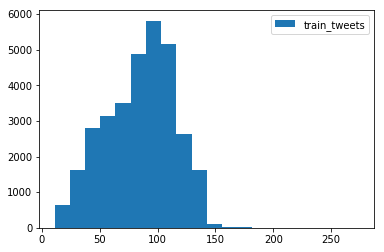

In [7]:
length_train = train['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.legend()
plt.show()

The tweet-length distribution is more or less the same in both train and test data.


### Data Cleaning

In [8]:
combi = train.append(test, ignore_index=True)
combi.shape

(49159, 3)

Given below is a user-defined function to remove unwanted text patterns from the tweets.

In [9]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

__1. Removing Twitter Handles (@user)__

In [10]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


__2. Removing Punctuations, Numbers, and Special Characters__

In [11]:
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here i m it s so #gr


__3. Removing Short Words__

In [12]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

Let’s take another look at the first few rows of the combined dataframe.

In [13]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


__4. Text Normalization__

Here we will use nltk's PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [14]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

In [15]:
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

Now we can normalize the tokenized tweets.

In [16]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

Now let’s stitch these tokens back together.

In [17]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
combi['tidy_tweet'] = tokenized_tweet

<br>
## Story Generation and Visualization from Tweets

__B) Words in non racist/sexist tweets__

In [18]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

__C) Racist/Sexist Tweets__

In [19]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])


As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

__D) Understanding the impact of Hashtags on tweets sentiment__

In [20]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [21]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top 'n' hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

__Non-Racist/Sexist Tweets__

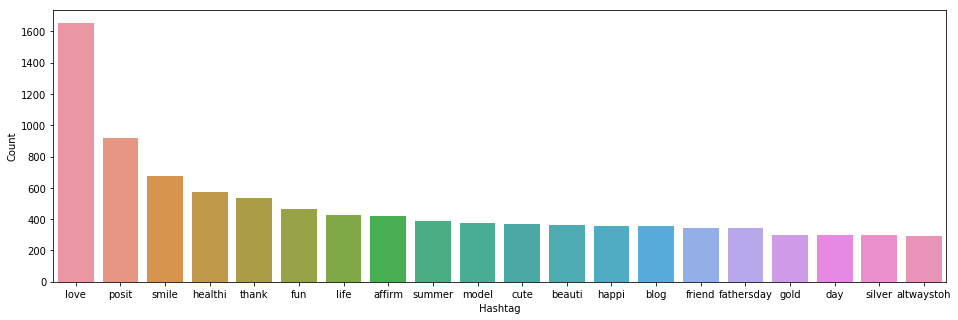

In [22]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

__Racist/Sexist Tweets__

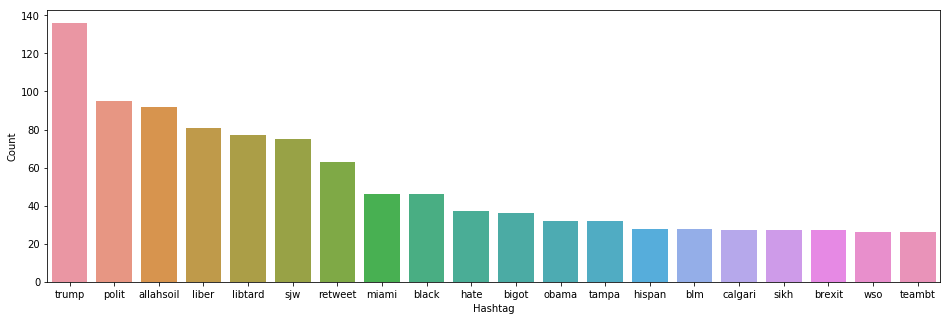

In [23]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 20 most frequent hashtags
e = e.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

## Extracting Features from Cleaned Tweets

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

### Bag-of-Words Features

In [25]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

### TF-IDF Features

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

### Word Embeddings

#### 1. Word2Vec Embeddings


In [27]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(6509771, 7536020)

Let's play a bit with our Word2Vec model and see how does it perform. We will specify a word and the model will pull out the most similar words from the corpus.

In [28]:
model_w2v.wv.most_similar(positive="dinner")

[('spaghetti', 0.5886623859405518),
 ('dess', 0.5683202743530273),
 ('#cellar', 0.5626382827758789),
 ('noodl', 0.5610578060150146),
 ('#biall', 0.5534021258354187),
 ('cookout', 0.5510768294334412),
 ('alfredo', 0.5454878807067871),
 ('#avocado', 0.5451971292495728),
 ('#foodcoma', 0.538665771484375),
 ('#tacotuesday', 0.5319042801856995)]

In [29]:
model_w2v.wv.most_similar(positive="trump")

[('phoni', 0.5460351705551147),
 ('donald', 0.5448886752128601),
 ('unfit', 0.5367486476898193),
 ('unstabl', 0.5354260206222534),
 ('nomine', 0.51901775598526),
 ('#delegaterevolt', 0.5163064002990723),
 ('jibe', 0.5162224173545837),
 ('irrefut', 0.5125339031219482),
 ('potu', 0.5119726657867432),
 ('melo', 0.5117800235748291)]

In [30]:
model_w2v['food']

array([-1.22882199e+00, -1.23320782e+00, -2.37327531e-01,  5.72909266e-02,
        1.28326550e-01, -2.33774688e-02,  8.46018046e-02,  1.51290849e-01,
        2.96935737e-01, -4.53928471e-01,  8.15902427e-02,  1.78488150e-01,
        6.26686394e-01, -3.15199792e-01,  5.73013484e-01,  8.01429272e-01,
        2.75204808e-01, -1.08179903e+00, -1.76856890e-01, -4.69208002e-01,
       -4.85175848e-01, -6.16316974e-01,  2.95484394e-01,  1.81930095e-01,
        2.58993059e-01, -2.55101360e-02,  2.40522511e-02, -1.21007061e+00,
        1.67439118e-01, -4.40018892e-01, -2.12097238e-03,  1.35335132e-01,
       -8.80088285e-03, -7.52070785e-01, -1.69576034e-01,  3.08519781e-01,
        2.26435624e-02, -2.90675052e-02,  4.69542593e-01, -3.11481446e-01,
       -5.20699620e-01, -7.26157963e-01,  1.98729813e-01,  4.46537063e-02,
       -1.21609911e-01, -4.27030414e-01,  1.65439203e-01,  2.42793605e-01,
        1.74261168e-01, -2.03208715e-01,  2.33801901e-02, -9.87570509e-02,
        4.57436651e-01, -

In [31]:
len(model_w2v['food']) #The length of the vector is 200

200

__Preparing Vectors for Tweets__

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [32]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

Preparing word2vec feature set...

In [33]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape    

(49159, 200)

Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features. 

---

## Model Building

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

1. Logistic Regression
2. Support Vector Machine
3. RandomForest
4. XGBoost

### 1. Logistic Regression

#### Bag-of-Words Features

In [40]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [76]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5303408146300915

#### TF-IDF Features

In [41]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [42]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.5451327433628319

#### Word2Vec Features

In [42]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [44]:
lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.6159582401193139

### 2. Support Vector Machine

#### Bag-of-Words Features

In [46]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.5102040816326531

#### TF-IDF Features

In [48]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.5104831358249772

Public Leaderboard F1 Score: 0.546

#### Word2Vec Features

In [49]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.615625

Public Leaderboard F1 Score: 0.654

### 3. RandomForest

#### Bag-of-Words Features

In [51]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.5529225908372828

#### TF-IDF Features

In [53]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.562152133580705

#### Word2Vec Features

In [54]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.49783549783549785

## Unsupervised:

In [147]:
sc = StandardScaler()
X_train_std = sc.fit_transform(xtrain_w2v)
X_test_std = sc.transform(xvalid_w2v)

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [177]:
gmm = GaussianMixture()
gmm.fit(X_train_pca)
prediction = gmm.predict(X_test_pca)
f1_score(yvalid, prediction)

0.0

In [178]:
kmeans = KMeans(2)#
kmeans.fit(X_train_pca)
prediction = kmeans.predict(X_test_pca)
f1_score(yvalid, prediction)

0.13662239089184058

In [131]:
isof = IsolationForest()
isof.fit(xtrain_w2v)
prediction = (isof.predict(xvalid_w2v) > 0).astype(int)
f1_score(yvalid, prediction)

0.13071363127354169

## AutoEncoder

In [160]:
encoding_dim = 500  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(1000,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Latent layer
latent = Dense(40, activation="relu")(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(1000, activation='sigmoid')(latent)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# intermediate result
# this model maps an input to its encoded representation
encoder = Model(input_img, latent)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

latenter = autoencoder.layers[-2]
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(latenter(encoded_input)))

autoencoder.compile(optimizer='adam', loss='mse', )

In [161]:
autoencoder.fit(xtrain_tfidf, xtrain_tfidf,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(xvalid_tfidf, xvalid_tfidf))

Train on 22373 samples, validate on 9589 samples
Epoch 1/10
22373/22373 [==============================] - 2s 100us/step - loss: 0.0232 - val_loss: 9.9215e-04
Epoch 2/10
22373/22373 [==============================] - 2s 70us/step - loss: 9.8072e-04 - val_loss: 9.7780e-04
Epoch 3/10
22373/22373 [==============================] - 2s 71us/step - loss: 9.7244e-04 - val_loss: 9.7414e-04
Epoch 4/10
22373/22373 [==============================] - 2s 72us/step - loss: 9.6984e-04 - val_loss: 9.7265e-04
Epoch 5/10
22373/22373 [==============================] - 2s 71us/step - loss: 9.6865e-04 - val_loss: 9.7186e-04
Epoch 6/10
22373/22373 [==============================] - 2s 70us/step - loss: 9.6793e-04 - val_loss: 9.7130e-04
Epoch 7/10
22373/22373 [==============================] - 2s 71us/step - loss: 9.6737e-04 - val_loss: 9.7077e-04
Epoch 8/10
22373/22373 [==============================] - 2s 71us/step - loss: 9.6678e-04 - val_loss: 9.7008e-04
Epoch 9/10
22373/22373 [==========================

In [162]:
train_encoded = encoder.predict(xtrain_tfidf)
valid_encoded = encoder.predict(xvalid_tfidf)

#sc = StandardScaler()
#X_train_std = sc.fit_transform(train_encoded)
#X_test_std = sc.transform(valid_encoded)

#pca = PCA(n_components=3)
#X_train_pca = pca.fit_transform(X_train_std)
#X_test_pca = pca.transform(X_test_std)

kmeans = KMeans(2)
kmeans.fit(train_encoded)
prediction = kmeans.predict(valid_encoded)
print('KMeans', f1_score(yvalid, prediction))

gmm = GaussianMixture()
gmm.fit(train_encoded)
prediction = gmm.predict(valid_encoded)
print('GaussianMixture:',f1_score(yvalid, prediction))

isof = IsolationForest()
isof.fit(train_encoded)
prediction = (isof.predict(valid_encoded) > 0).astype(int)
print('Isolation Forest', f1_score(yvalid, prediction))

KMeans 0.1389059618930547
GaussianMixture: 0.0
Isolation Forest 0.13830285982184715


# BERT

In [21]:
import torch
from transformers import *

MODELS = [(BertModel, BertTokenizer, 'bert-base-uncased') ]

# Let's encode some text in a sequence of hidden-states using each model:
for model_class, tokenizer_class, pretrained_weights in MODELS:
    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

**12-layer, 768-hidden, 12-heads, 110M parameters.
Trained on lower-cased English text.**

In [22]:
def generate_bert_embedding(data):
    embeddings = []
    for sent in data:
        # Encode text
        input_ids = torch.tensor([tokenizer.encode(sent, add_special_tokens=True)]) 
        with torch.no_grad():
            last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples
        last_hidden_states = torch.mean(last_hidden_states, dim=1)    
        embeddings.append(last_hidden_states)
    return embeddings

def reduce_data(test_data, reduction_perc):
    normal = test_data[test_data['labels'] == 0]
    abnormal = test_data[test_data['labels'] == 1]
    abnormal_reduced = abnormal.sample(int(len(abnormal) * (1-reduction_perc)))
    return shuffle(pd.concat([normal, abnormal_reduced]))

In [25]:
from time import time

data = combi[combi['label'].notnull()]!
X_train, X_test, y_train, y_test = train_test_split(data, data['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

X_train_embed = generate_bert_embedding(X_train['tidy_tweet'])
X_test_embed = generate_bert_embedding(X_test['tidy_tweet'])

train_labels = combi.iloc[X_train['tidy_tweet'].index]['label'].values
test_labels = combi.iloc[X_test['tidy_tweet'].index]['label'].values

embedding_data = X_train_embed + X_test_embed
embedding_labels = np.concatenate((train_labels,test_labels))

embedding_data_np = list(map(lambda x : x.numpy(), embedding_data))
embedding_df = pd.DataFrame(list(zip(embedding_data_np, embedding_labels)), columns=['data', 'labels'])

normal_data = embedding_df[embedding_df['labels'] == 0]
abnormal_data = embedding_df[embedding_df['labels'] == 1]

In [121]:
supervised_models = ['LogisticRegression', 'SVC', 'DecisionTreeClassifier']
unsupervised_models = ['KMeans', 'GaussianMixture', 'IsolationForest', 'LocalOutlierFactor']

In [ ]:
results = []

model = LocalOutlierFactor(novelty=True)
model_name = type(model).__name__

for train_ratio in [0.5, 0.75, 0.9]:
    #Split training test data
    X_train_normal, X_test_normal = train_test_split(normal_data, train_size=train_ratio)
    X_train_abnormal, X_test_abnormal = train_test_split(abnormal_data, train_size=train_ratio)

    train_data = pd.concat([X_train_normal, X_train_abnormal])
    test_data  = pd.concat([X_test_normal, X_test_abnormal])

    train_data['data'] = train_data['data'].apply(lambda x : x.reshape((768,)))
    test_data['data'] = test_data['data'].apply(lambda x : x.reshape((768,)))

    #Change data to proper format
    x_tr, y_tr = np.stack(train_data['data'].values), train_data['labels']
   
    #Oversampling
    ros = RandomOverSampler()
    X_res, y_res = ros.fit_resample(x_tr, y_tr)
    if(model_name in supervised_models):
        model.fit(X_res, y_res)
    else:
        model.fit(x_tr)
    
    for reduction_perc in [0, 0.25, 0.5, 0.75, 0.99, 0.999]:
        test_data_reduced = reduce_data(test_data, reduction_perc)
        
        x_te, y_te = np.stack(test_data_reduced['data'].values), test_data_reduced['labels']
          
        prediction = model.predict(x_te)
        
        if(model_name == 'IsolationForest' or model_name == 'LocalOutlierFactor'):
            prediction = (prediction < 0).astype(int)
        
        f_score = f1_score(y_te, prediction)

        results.append((type(model).__name__, train_ratio, reduction_perc, f_score))

In [200]:
results_df = pd.DataFrame(results, columns=['model', 'train_ratio', 'reduction', 'f_score'])
results_df_grouped = results_df.groupby(['model', 'train_ratio', 'reduction']).agg(np.mean)

In [208]:
supervised_models = ['LogisticRegression', 'DecisionTreeClassifier', 'SVC']
unsupervised_models = ['KMeans', 'LocalOutlierFactor', 'IsolationForest', 'GaussianMixture']
random_models = [x for x in results_df.model if 'random' in x]

def pick(results, train_ratio=None, reduction_train=None, reduction_test=None, model=None):
    tmp = results
    if(train_ratio != None):
        tmp = tmp[(tmp.index.get_level_values('train_ratio') == train_ratio)]
    if(reduction_test != None):
        tmp = tmp[(tmp.index.get_level_values('reduction_test') == reduction_test)]
    if(model != None):
        tmp = tmp.loc[model]
    return tmp

def compute_lip(model, results, lipschitz, train_ratio, reduction_train=None, reduction_test=None):
    test_f1 = pick(results, train_ratio=train_ratio, reduction_train=reduction_train,  reduction_test=reduction_test, model=model).values
    final_results = []
    for i in range(len(test_f1)):
        elem_i = test_f1[i]
        for j in range(i+1, len(test_f1)):
            elem_j = test_f1[j]
            if(lipschitz):
                lipschitz_cte_estimator = (abs(elem_j-elem_i)/abs(j-i))
                final_results.append((j-i, lipschitz_cte_estimator))
            else:
                final_results.append(((j-i), (elem_j-elem_i)**2))
    final_results.sort(key=lambda tup: tup[0])  # sorts in place
    return final_results, np.mean([x[1] for x in final_results])
    
def plot_distance_performance(model,l , ax, marker):
    d = defaultdict(list)
    distance_performance = []
    for key, value in l:
        d[key].append(value)

    for key in d:
        distance_performance.append((key, np.mean(d[key])))

    ax.scatter(*zip(*distance_performance), label=model, marker=marker, s=50, alpha=0.8)

In [209]:
reduction_train= 0
lipschitz = True
training_ratios = [0.5, 0.75, 0.9]
lipschitz_per_model = []

for training_ratio in training_ratios:
    for model in set(results_df.model):
        l, mean_lip = compute_lip(model, results_df_grouped, lipschitz, training_ratio, reduction_train)
        lipschitz_per_model.append((model, training_ratio, mean_lip))

In [219]:
results_df_grouped.head()

f_score
model                  train_ratio reduction          
DecisionTreeClassifier 0.5         0.00       0.383745
                                   0.25       0.340383
                                   0.50       0.274905
                                   0.75       0.176027
                                   0.99       0.019347

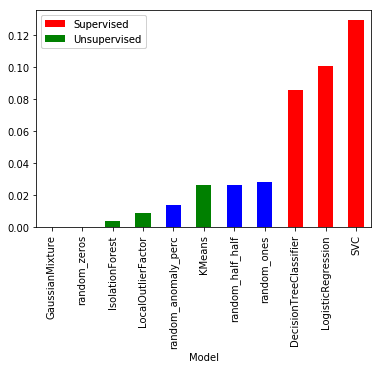

In [210]:
fig, ax = plt.subplots()

robustness_df = pd.DataFrame(lipschitz_per_model, columns=['Model', 'train_ratio', 'lipschitz'])
robustness_df_grouped = robustness_df.groupby(['Model']).agg(np.mean)['lipschitz'].sort_values()
color_code = ['r' if x in supervised_models else 'g' if (x in unsupervised_models) else 'b' for x in robustness_df_grouped.index]

robustness_df_grouped.plot.bar(color=color_code)

legend_elements = [Patch(facecolor='r',label='Supervised'),
                   Patch(facecolor='g',label='Unsupervised')]

legend = ax.legend(handles=legend_elements, loc=2)
ax.add_artist(legend)

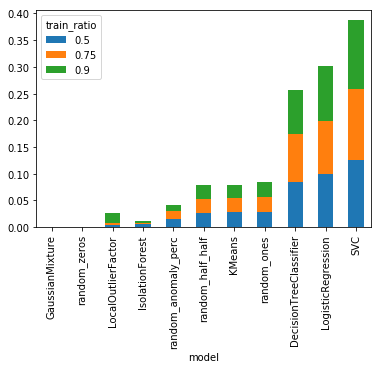

In [211]:
lip_df = pd.DataFrame(lipschitz_per_model, columns=['model', 'train_ratio', 'Lipschitz_constant'])
lip_df.pivot(index='model', columns='train_ratio', values='Lipschitz_constant').sort_values(by=0.5).plot(kind='bar', stacked=True)

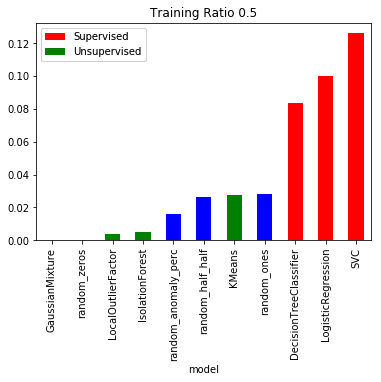

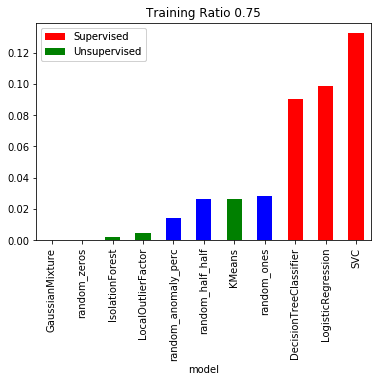

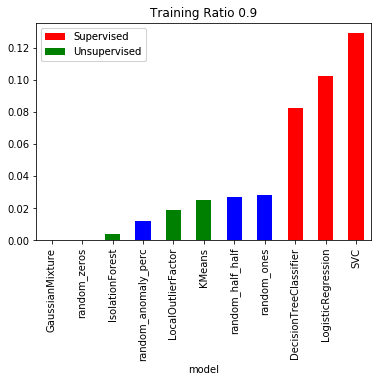

In [212]:
for train_ratio in [0.5, 0.75, 0.9]:
    fig, ax = plt.subplots()
    sorted_lip = lip_df[lip_df.train_ratio == train_ratio].set_index('model')['Lipschitz_constant'].sort_values()
    color_code = ['r' if x in supervised_models else 'g' if (x in unsupervised_models) else 'b' for x in sorted_lip.index]

    sorted_lip.plot.bar(color=color_code)
    plt.title('Training Ratio ' + str(train_ratio))
    
    legend_elements = [Patch(facecolor='r',label='Supervised'),
                       Patch(facecolor='g',label='Unsupervised')]

    legend = ax.legend(handles=legend_elements, loc=2)
    ax.add_artist(legend)

In [231]:
results_df[(results_df.model == 'DecisionTreeClassifier') & (results_df.reduction == 0.0)]

,model,train_ratio,reduction,f_score
18,DecisionTreeClassifier,0.50,0.0,0.383745
24,DecisionTreeClassifier,0.75,0.0,0.410167
30,DecisionTreeClassifier,0.90,0.0,0.379381


## Models 

In [178]:
model = LogisticRegression()
model_name = type(model).__name__

for train_ratio in [0.5, 0.75, 0.9]:
    #Split training test data
    X_train_normal, X_test_normal = train_test_split(normal_data, train_size=train_ratio)
    X_train_abnormal, X_test_abnormal = train_test_split(abnormal_data, train_size=train_ratio)

    train_data = pd.concat([X_train_normal, X_train_abnormal])
    test_data  = pd.concat([X_test_normal, X_test_abnormal])

    train_data['data'] = train_data['data'].apply(lambda x : x.reshape((768,)))
    test_data['data'] = test_data['data'].apply(lambda x : x.reshape((768,)))

    #Change data to proper format
    x_tr, y_tr = np.stack(train_data['data'].values), train_data['labels']
    pca = PCA(0.99) 
    
    x_tr_pca = pca.fit_transform(x_tr)
    
    #Oversampling
    ros = RandomOverSampler()
    X_res, y_res = ros.fit_resample(x_tr_pca, y_tr)
    if(model_name in supervised_models):
        model.fit(X_res, y_res)
    else:
        model.fit(x_tr_pca)
    
    for reduction_perc in [0, 0.25, 0.5, 0.75, 0.99, 0.999]:
        test_data_reduced = reduce_data(test_data, reduction_perc)
        
        x_te, y_te = np.stack(test_data_reduced['data'].values), test_data_reduced['labels']
        
        x_te_pca = pca.transform(x_te)
        
        prediction = model.predict(x_te_pca)
        
        if(model_name == 'IsolationForest' or model_name == 'LocalOutlierFactor'):
            prediction = (prediction < 0).astype(int)
        
        f_score = f1_score(y_te, prediction)

        print(((type(model).__name__, train_ratio, reduction_perc, f_score)))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


('LogisticRegression', 0.5, 0, 0.4396837541443509)
('LogisticRegression', 0.5, 0.25, 0.3778102189781022)
('LogisticRegression', 0.5, 0.5, 0.2931329005807995)
('LogisticRegression', 0.5, 0.75, 0.17748562037797863)
('LogisticRegression', 0.5, 0.99, 0.009193054136874362)
('LogisticRegression', 0.5, 0.999, 0.0010309278350515464)


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


('LogisticRegression', 0.75, 0, 0.43302928468554963)
('LogisticRegression', 0.75, 0.25, 0.3749318801089918)
('LogisticRegression', 0.75, 0.5, 0.29203539823008845)
('LogisticRegression', 0.75, 0.75, 0.17483044461190655)
('LogisticRegression', 0.75, 0.99, 0.007407407407407408)
('LogisticRegression', 0.75, 0.999, 0.0)


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


('LogisticRegression', 0.9, 0, 0.44913151364764264)
('LogisticRegression', 0.9, 0.25, 0.38636363636363635)
('LogisticRegression', 0.9, 0.5, 0.2961730449251248)
('LogisticRegression', 0.9, 0.75, 0.19047619047619047)
('LogisticRegression', 0.9, 0.99, 0.0099009900990099)
('LogisticRegression', 0.9, 0.999, 0.0)


**==> PCA no help in performance:
http://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26635301.pdf**

## Baselines

In [196]:
for train_ratio in [0.5, 0.75, 0.9]:
    #Split training test data
    X_train_normal, X_test_normal = train_test_split(normal_data, train_size=train_ratio)
    X_train_abnormal, X_test_abnormal = train_test_split(abnormal_data, train_size=train_ratio)

    train_data = pd.concat([X_train_normal, X_train_abnormal])
    test_data  = pd.concat([X_test_normal, X_test_abnormal])

    train_data['data'] = train_data['data'].apply(lambda x : x.reshape((768,)))
    test_data['data'] = test_data['data'].apply(lambda x : x.reshape((768,)))

    #Change data to proper format
    x_tr, y_tr = np.stack(train_data['data'].values), train_data['labels']
   
    for reduction_perc in [0, 0.25, 0.5, 0.75, 0.99, 0.999]:
        test_data_reduced = reduce_data(test_data, reduction_perc)
        
        x_te, y_te = np.stack(test_data_reduced['data'].values), test_data_reduced['labels']
          
        anomaly_perc = sum(y_tr)/len(y_tr)
        prediction = np.random.choice([0, 1], size=(len(y_te),), p=[1-anomaly_perc, anomaly_perc])
        
        if(model_name == 'IsolationForest' or model_name == 'LocalOutlierFactor'):
            prediction = (prediction < 0).astype(int)
        
        f_score = f1_score(y_te, prediction)

        results.append(('random_anomaly_perc', train_ratio, reduction_perc, f_score))